Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  7195 non-null   float64
 1   MFCCs_ 2  7195 non-null   float64
 2   MFCCs_ 3  7195 non-null   float64
 3   MFCCs_ 4  7195 non-null   float64
 4   MFCCs_ 5  7195 non-null   float64
 5   MFCCs_ 6  7195 non-null   float64
 6   MFCCs_ 7  7195 non-null   float64
 7   MFCCs_ 8  7195 non-null   float64
 8   MFCCs_ 9  7195 non-null   float64
 9   MFCCs_10  7195 non-null   float64
 10  MFCCs_11  7195 non-null   float64
 11  MFCCs_12  7195 non-null   float64
 12  MFCCs_13  7195 non-null   float64
 13  MFCCs_14  7195 non-null   float64
 14  MFCCs_15  7195 non-null   float64
 15  MFCCs_16  7195 non-null   float64
 16  MFCCs_17  7195 non-null   float64
 17  MFCC

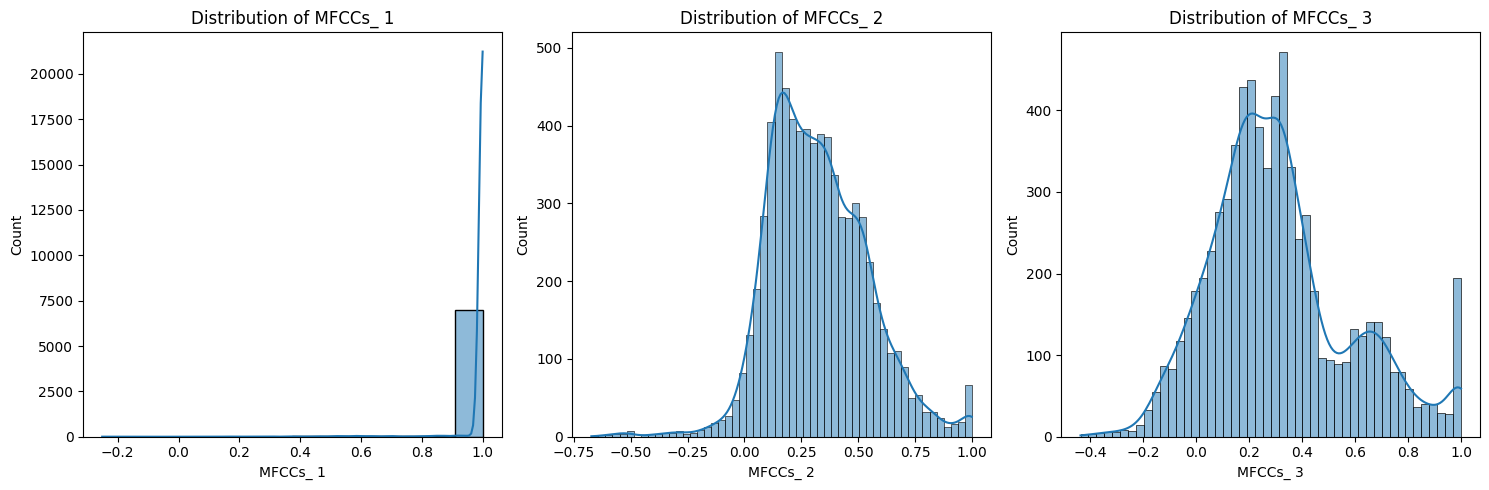

[saved fig] outputs/figures/feature_correlation_matrix.png


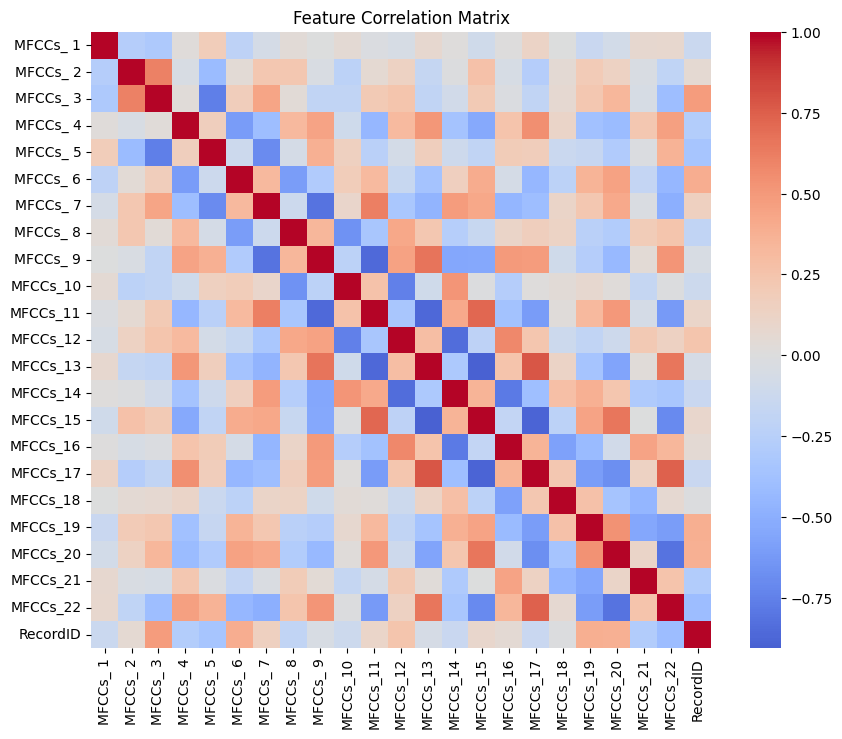

[saved model] outputs/models/standard_scaler.joblib
[saved model] outputs/models/pca_10_components.joblib
[saved csv] outputs/metrics/pca_explained_variance.csv
[saved fig] outputs/figures/pca_cumulative_explained_variance.png


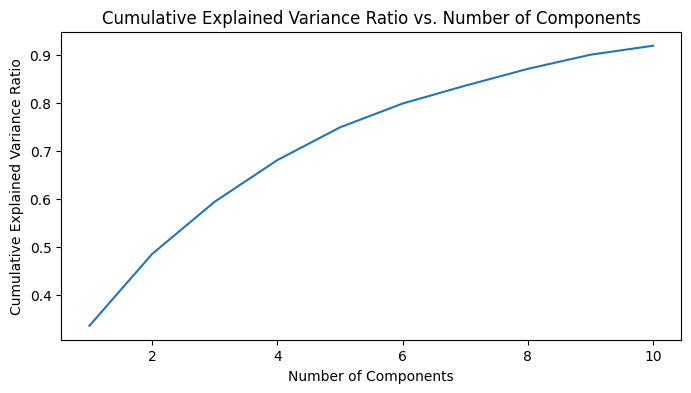

[saved artifact] outputs/artifacts/pca_embedding_pc1_pc3.csv
[saved csv] outputs/metrics/elbow_wcss.csv
[saved fig] outputs/figures/elbow_method.png


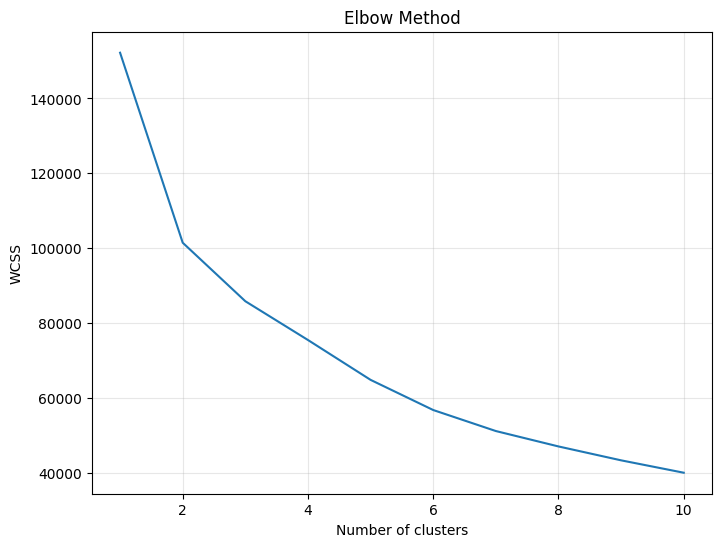


K-means initialization comparison: {'random': np.float64(0.4017217181825454), 'k-means++': np.float64(0.40127709594952254)}
[saved json] outputs/metrics/kmeans_init_comparison.json
[saved model] outputs/models/kmeans_k4_kpp.joblib
[saved artifact] outputs/artifacts/kmeans_labels_k4.csv
[saved fig] outputs/figures/feature_importance_clustering.png


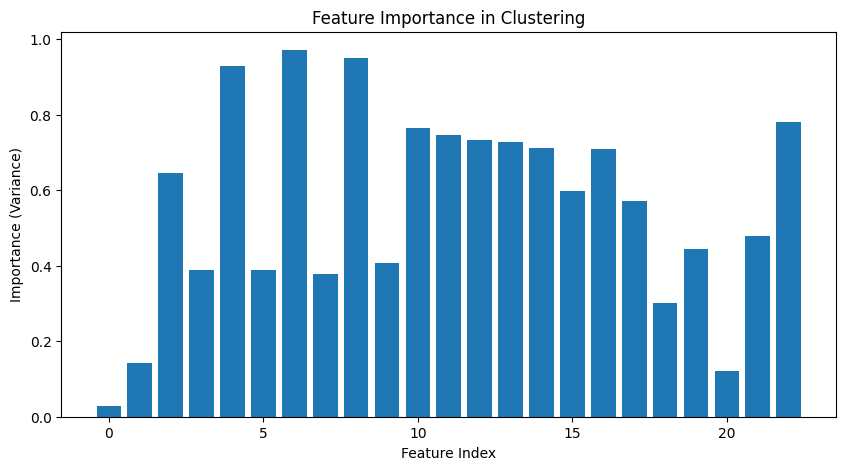

[saved csv] outputs/metrics/feature_importance_vector.csv

Top 5 most important features: [10 22  4  8  6]

K-Means: Silhouette Score=0.401, Davies-Bouldin Index=1.284, Calinski-Harabasz Index=2436.411
[saved csv] outputs/metrics/kmeans_metrics.csv
Hierarchical Clustering: Silhouette=0.366, Davies-Bouldin=1.499, Calinski-Harabasz=2366.501
[saved csv] outputs/metrics/hierarchical_metrics.csv
[saved artifact] outputs/artifacts/hierarchical_labels_k4.csv
[saved model] outputs/models/dbscan_eps0p5_min5.joblib
DBSCAN: Silhouette=-0.434, Davies-Bouldin=1.488, Calinski-Harabasz=23.272
Number of clusters found by DBSCAN: 44
[saved csv] outputs/metrics/dbscan_metrics.csv
[saved artifact] outputs/artifacts/dbscan_labels.csv
[saved fig] outputs/figures/clustering_comparison_pc12.png


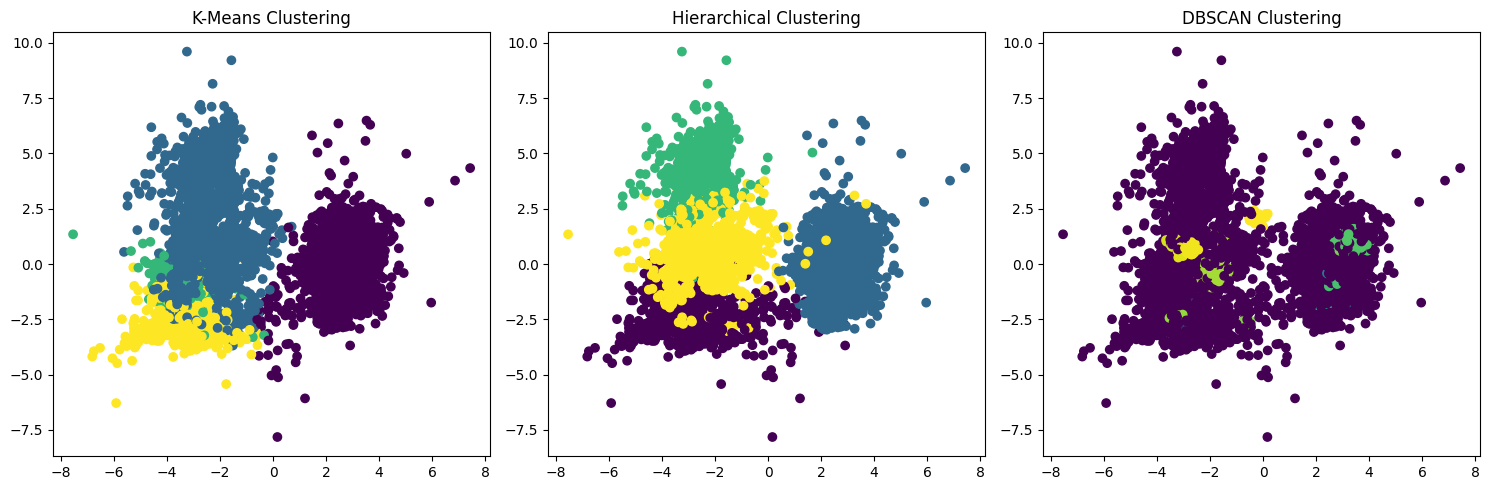

[saved csv] outputs/metrics/all_clustering_metrics.csv

Done. All figures, models, metrics, and artifacts saved under outputs/ for Part B.


In [ ]:
# ====== Setup & Imports ======
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from joblib import dump
from google.colab import drive
drive.mount('/content/drive')

# Set random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ====== Output directories ======
BASE_OUT = "outputs"
DIRS = {
    "fig": os.path.join(BASE_OUT, "figures"),
    "models": os.path.join(BASE_OUT, "models"),
    "metrics": os.path.join(BASE_OUT, "metrics"),
    "artifacts": os.path.join(BASE_OUT, "artifacts")
}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

# ====== Utility: save fig / json / csv / model ======
def save_fig(name):
    path = os.path.join(DIRS["fig"], f"{name}.png")
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print(f"[saved fig] {path}")

def save_csv(df, name):
    path = os.path.join(DIRS["metrics"], f"{name}.csv")
    df.to_csv(path, index=False)
    print(f"[saved csv] {path}")

def save_json(obj, name):
    path = os.path.join(DIRS["metrics"], f"{name}.json")
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"[saved json] {path}")

def save_artifact(df_or_arr, name):
    path = os.path.join(DIRS["artifacts"], f"{name}.csv")
    if isinstance(df_or_arr, pd.DataFrame):
        df_or_arr.to_csv(path, index=False)
    else:
        pd.DataFrame(df_or_arr).to_csv(path, index=False)
    print(f"[saved artifact] {path}")

def save_model(model, name):
    path = os.path.join(DIRS["models"], f"{name}.joblib")
    dump(model, path)
    print(f"[saved model] {path}")

# Load the data
data = pd.read_csv('/content/drive/MyDrive/Frogs_MFCCs.csv')

# 1. Data Preprocessing and Exploration
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nBasic Statistics:")
print(data.describe())

# ====== EDA: distributions and correlation ======
plt.figure(figsize=(15, 5))
for i, column in enumerate(data.select_dtypes(include=np.number).columns[:3]):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
save_fig("distributions_first_3_numeric")
plt.show()

# ====== Feature Correlation Analysis ======
corr_matrix = data.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
save_fig("feature_correlation_matrix")
plt.show()

# ====== Remove highly correlated features (threshold = 0.95) ======
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_df = data.drop(columns=to_drop).select_dtypes(include=np.number)
X = X_df.values
y = data.iloc[:, -1].values
pd.DataFrame({"dropped_feature": to_drop}).to_csv(
    os.path.join(DIRS["metrics"], "high_corr_dropped_features.csv"), index=False
)

if "RecordID" in data.columns:
    record_ids = data["RecordID"].values
else:
    record_ids = np.arange(len(data))

# ====== Feature Engineering ======
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X[:, :5])
X = np.hstack((X, X_poly[:, X.shape[1]:]))

# ====== Scaling ======
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
save_model(scaler, "standard_scaler")

# ====== Dimensionality reduction using PCA ======
pca = PCA(n_components=10, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
save_model(pca, "pca_10_components")

# Save PCA explained variance
pca_var = pd.DataFrame({
    "component": np.arange(1, len(pca.explained_variance_ratio_) + 1),
    "explained_variance_ratio": pca.explained_variance_ratio_,
    "cumulative": np.cumsum(pca.explained_variance_ratio_)
})
save_csv(pca_var, "pca_explained_variance")

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
save_fig("pca_cumulative_explained_variance")
plt.show()

# Save embeddings for plotting/reuse
emb_df = pd.DataFrame(X_pca[:, :3], columns=["PC1", "PC2", "PC3"])
emb_df["RecordID"] = record_ids
save_artifact(emb_df, "pca_embedding_pc1_pc3")

# Elbow method to find optimal number of clusters
wcss = []
ks = list(range(1, 11))
for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

elbow_df = pd.DataFrame({"k": ks, "wcss": wcss})
save_csv(elbow_df, "elbow_wcss")

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
# plt.plot(ks, wcss, marker="o")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(alpha=0.3)
save_fig("elbow_method")
plt.show()

# ====== Compare different initialization methods(random vs k-means++) ======
kbest_clusters = 4
init_methods = ['random', 'k-means++']
init_scores = {}
for init in init_methods:
    kmeans_init = KMeans(n_clusters=kbest_clusters, init=init, max_iter=300, n_init=10, random_state=RANDOM_STATE)
    labels_init = kmeans_init.fit_predict(X_pca)
    init_scores[init] = silhouette_score(X_pca, labels_init)
print("\nK-means initialization comparison:", init_scores)
save_json(init_scores, "kmeans_init_comparison")

# ====== K-Means Clustering with optimal parameters ======
kmeans = KMeans(n_clusters=kbest_clusters, init='k-means++', max_iter=300, n_init=10, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(X_pca)
save_model(kmeans, f"kmeans_k{kbest_clusters}_kpp")

# Save labels
save_artifact(pd.DataFrame({"RecordID": record_ids, "kmeans_label": kmeans_labels}), f"kmeans_labels_k{kbest_clusters}")

# ====== Analyze feature contribution to clustering ======
def analyze_feature_importance(kmeans, pca, feature_names):
    # Get cluster centers in original space
    centers_pca = kmeans.cluster_centers_
    centers_original = pca.inverse_transform(centers_pca)

    # Calculate feature importance as variance of cluster centers
    feature_importance = np.var(centers_original, axis=0)

    # Plot feature importance
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title('Feature Importance in Clustering')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance (Variance)')
    save_fig("feature_importance_clustering")
    plt.show()

    # Save vector with names (best effort: generated features appended)
    idx = np.arange(len(feature_importance))
    names = []
    base_names = list(X_df.columns)
    # approximate names for engineered part
    extra_count = len(feature_importance) - len(base_names)
    names.extend(base_names)
    names.extend([f"poly_extra_{i+1}" for i in range(extra_count)])
    imp_df = pd.DataFrame({"feature": names, "importance_variance": feature_importance})
    save_csv(imp_df, "feature_importance_vector")

    return feature_importance

feature_importance = analyze_feature_importance(kmeans, pca, X_df.columns)
print("\nTop 5 most important features:", np.argsort(feature_importance)[-5:])

# ====== Evaluate K-Means ======
silhouette_avg = silhouette_score(X_pca, kmeans_labels)
db_index = davies_bouldin_score(X_pca, kmeans_labels)
ch_index = calinski_harabasz_score(X_pca, kmeans_labels)
print(f'\nK-Means: Silhouette Score={silhouette_avg:.3f}, Davies-Bouldin Index={db_index:.3f}, Calinski-Harabasz Index={ch_index:.3f}')
kmeans_metrics = pd.DataFrame([{
    "method": "KMeans",
    "k": kbest_clusters,
    "silhouette": silhouette_avg,
    "davies_bouldin": db_index,
    "calinski_harabasz": ch_index
}])
save_csv(kmeans_metrics, "kmeans_metrics")

# ====== Hierarchical Clustering ======
hierarchical = AgglomerativeClustering(n_clusters=kbest_clusters)
hierarchical_labels = hierarchical.fit_predict(X_pca)

h_silhouette = silhouette_score(X_pca, hierarchical_labels)
h_db = davies_bouldin_score(X_pca, hierarchical_labels)
h_ch = calinski_harabasz_score(X_pca, hierarchical_labels)
print(f'Hierarchical Clustering: Silhouette={h_silhouette:.3f}, Davies-Bouldin={h_db:.3f}, Calinski-Harabasz={h_ch:.3f}')

hier_metrics = pd.DataFrame([{
    "method": "Agglomerative",
    "k": kbest_clusters,
    "silhouette": h_silhouette,
    "davies_bouldin": h_db,
    "calinski_harabasz": h_ch
}])
save_csv(hier_metrics, "hierarchical_metrics")

save_artifact(pd.DataFrame({"RecordID": record_ids, "hierarchical_label": hierarchical_labels}), f"hierarchical_labels_k{kbest_clusters}")

# ====== DBSCAN ======
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)
save_model(dbscan, "dbscan_eps0p5_min5")

# Count clusters (excluding noise -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_metrics = []

if len(set(dbscan_labels[dbscan_labels >= 0])) > 1:
    db_silhouette = silhouette_score(X_pca, dbscan_labels)
    db_db = davies_bouldin_score(X_pca, dbscan_labels)
    db_ch = calinski_harabasz_score(X_pca, dbscan_labels)
    print(f'DBSCAN: Silhouette={db_silhouette:.3f}, Davies-Bouldin={db_db:.3f}, Calinski-Harabasz={db_ch:.3f}')
    dbscan_metrics.append({
        "method": "DBSCAN",
        "clusters": n_clusters_dbscan,
        "silhouette": db_silhouette,
        "davies_bouldin": db_db,
        "calinski_harabasz": db_ch
    })
else:
    dbscan_metrics.append({
        "method": "DBSCAN",
        "clusters": n_clusters_dbscan,
        "silhouette": np.nan,
        "davies_bouldin": np.nan,
        "calinski_harabasz": np.nan
    })

print(f'Number of clusters found by DBSCAN: {len(set(dbscan_labels))-1 if -1 in dbscan_labels else len(set(dbscan_labels))}')
save_csv(pd.DataFrame(dbscan_metrics), "dbscan_metrics")
save_artifact(pd.DataFrame({"RecordID": record_ids, "dbscan_label": dbscan_labels}), "dbscan_labels")

# Visualize results from different algorithms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')

plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title('Hierarchical Clustering')

plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')

plt.tight_layout()
save_fig("clustering_comparison_pc12")
plt.show()


# ====== Aggregate metrics report ======
all_metrics = pd.concat([kmeans_metrics, hier_metrics, pd.DataFrame(dbscan_metrics)], ignore_index=True)
save_csv(all_metrics, "all_clustering_metrics")

print("\nDone. All figures, models, metrics, and artifacts saved under outputs/ for Part B.")